##  Chapter 8: Linear Unsupervised Learning

# 8.4  The Linear Autoencoder

Following the discussion of the previous Section - here we look at the problem of learning *orthogonal* bases via the so-called *Linear Autoencoder* (also referred to simply as the *Autoencoder* for short).  This will lead to the our final discussion of the classic orthogonal PCA basis - a very special global minimum of the autoencoder cost function - in the Section following this one.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import math_optimization_library as optlib
optimizers = optlib.optimizers
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# plotting utilities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# This is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 8.4.1 Othogonal spanning sets and the PCA Least Squares

In the [Section 8.2](https://jermwatt.github.io/machine_learning_refined/notes/8_Linear_unsupervised_learning/8_2_Spanning.html) we examined the special case of an *orthogonal basis* or spanning set, one whose members are perpendicular to one another and have unit length.  This set of conditions can be written mathematically *for any orthogonal basis* as

\begin{array}
\
\mathbf{c}_n^T\mathbf{c}_m^{\,} = 0 \\
\left \Vert \mathbf{c}_n \right \Vert_2^2 = 1 \,\,\,\,\text{for}\,\,n=1...K
\end{array}

or all together in a single line using matrix notation as 

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{K\times K}
\end{equation}


where $\mathbf{C}$ is the basis matrix built by stacking the spanning vectors columnwise and $\mathbf{I}_{K\times K}$ is the $K \times K$ identity matrix (i.e., all ones along the diagonal, zeros everywhere else).  

Importantly we saw how the use of **any** fixed orthogonal basis significantly simplifies the computation of weight / encoding vectors $\mathbf{w}_p$.  More specifically we saw how the typical computation for the weight / encoding vector $\mathbf{w}_p$ of the $p^{th}$ point $\mathbf{x}_p$ using any *fixed* basis $\mathbf{C}$ of $K$ vectors simplifies from the typical linear system of equations (which must be solved for a standard fixed basis)

\begin{equation}
\mathbf{C}^T\mathbf{C}^{\,}\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

to the considerably simpler set of computations (since indeed $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{K\times K}$)

\begin{equation}
\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p      \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1...P.
\end{equation} 

Now, notice one consequence of this update formula.  Since it holds for *any orthogonal matrix*, if we have such a basis we can readily plug in the solution to each $\mathbf{w}_p$ right back into each summand of the original Least Squares cost function in equation (2) giving

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2 = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

The formula on the right is interesting in that - again under the assumption that $\mathbf{C}$ is orthogonal - the corresponding Least Squares cost function does not contain weight / encoding vectors *explicitly* (but *implicitly* as the computations $\mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p$).  This version of the Least Squares cost - where the given basis is assumed orthogonal - can also be derived geometrically by looking at how each data point is represented over such a basis - as illustrated in the figure below.

(Note: if $\mathbf{C}$ has $N$ entries (and so is size $N \times N$) then it is the case that $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T = \mathbf{I}_{N\times N}$ and each summand above simplifies to $\left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2 = \left \Vert \mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2 = 0$.  However note that if $K < N$ then $\mathbf{C}^T\mathbf{C}^{\,} \neq \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T$ and so such simplification does not occur.  Indeed in this case $\mathbf{C}^T\mathbf{C}^{\,}$ is a $K \times K$ matrix, while $\mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T$ is $N\times N$.)

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/autoencoder_geometry.png' width="95%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> 
The geometry of projecting a point $\mathbf{x}$ onto a basis of orthogonal vectors, shown when using $K = 1$ vectors in the left panel and $K = 2$ in the right.  (left panel) The general projection (or decoding) of a point $\mathbf{x}$ onto a single basis vector $\mathbf{c}$ simplifies from $\mathbf{c}\frac{\mathbf{c}^T\mathbf{x}}{\mathbf{c}^T\mathbf{c}}$ to just $\mathbf{c}\mathbf{c}^T\mathbf{x}$ when $\mathbf{c}$ is orthogonal. This decoded point - living in the space spanned by $\mathbf{c}$ - is the point on $\mathbf{c}$ that lies closest to $\mathbf{x}$ and so minimizes the distance $\left\Vert \mathbf{c}\mathbf{c}^T\mathbf{x} - \mathbf{x}\right\Vert_2$.  (right panel)  The analogous scenario with two orthogonal vectors.  The projection / decoding of a point $\mathbf{x}$ over two orthogonal basis vectors $\mathbf{C} = 
\begin{bmatrix}
\vert \,\,\,\,\, \vert \,\,\,  \\
\mathbf{c}_1 \,\,\, \mathbf{c}_2 \\
\vert \,\,\,\,\, \vert \,\,\, 
\end{bmatrix}
$
is similarly given as $\mathbf{C}\mathbf{C}^T\mathbf{x}$.  This point - in the space spanned by the two basis vectors - is the point closest to $\mathbf{x}$ of those living in this plane, and so minimizes the error $\left\Vert \mathbf{C}\mathbf{C}^T\mathbf{x} - \mathbf{x}\right\Vert_2$.  Note we only square this error in the autoencoder cost so that we can more easily differentiate it and apply e.g., gradient descent to its minimization.
  </em>  </figcaption> 
</figure>

## 8.4.2 The Autoencoder cost function

Now if we turn the tables and return to main problem in this Section of *learning* proper bases, notice that if we constrain our search to only *orthogonal* matrices $\mathbf{C}$ where $\mathbf{C}^T\mathbf{C}^{\,} = \mathbf{I}_{K\times K}$ then - just as with the cost function above - the PCA Least Squares cost function in equation (3) likewise simplifies to 

\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}\mathbf{w}_p - \mathbf{x}_p \right\Vert_2^2 = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}


This is interesting because - so long as we enforce the orthogonality constraint - the cost function above is no longer a function of the weight / encoding vectors, and is *only a function of $\mathbf{C}$*.  Therefore we can write it as 

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2.
\end{equation}

This simplified version of the PCA Least Squares cost function is often referred to as the **Linear Autoencoder** or simply the **Autoencoder**.  Why does it go by this name?  Because when we minimize the original PCA Least Squares cost we find both the best encoding (provided by the learned weights $\mathbf{w}_p$) and decoding (provided by the projection via the learned basis / encoding product $\mathbf{C}\mathbf{w}_p$) for a given dataset.  In this form of the cost function we still do this - but here learn the encoding / decoding of each $\mathbf{x}_p$ in terms of *itself*.  In particular the *encoding* of the $p^{th}$ point $\mathbf{x}_p$ will be - when the cost is entirely tuned and we have an ideal basis $\mathbf{C}$ - expressed in this way as

\begin{equation}
\left(\text{encoding}\right) \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \mathbf{w}_p = \mathbf{C}^T\mathbf{x}_p
\end{equation}

and the decoding of this point likewise as 

\begin{equation}
\,\,\, \left(\text{decoding}\right) \,\,\,\,\,\, \mathbf{C}_{\,}^T\mathbf{w}_p  = \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p. \,
\end{equation}

We can see too that in minimizing the autoencoder we aim to make each summand $\left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2$ as small as possible.  So in minimizing each of these squared error terms we are *regressing* every data point against itself in the hopes of forcing the approximations

\begin{equation}
\mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p \approx \mathbf{x}_p    \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p = 1,...,P
\end{equation}

to be as close to equality as possible.  

This is true even if we do not strictly enforce the orthogonality constraint as well.  Indeed one can show - as we do in the appendix of this Section - that *global minima of the Autoencoder are always orthogonal matrices* irregardless if we strictly enforce orthogonality ourselves.  This makes the need for an explicit orthogonality constraint somewhat redundant and so more often than not we simply *disregard the explicit orthogonality constraint* and minimize the autoencoder cost function above directly using e.g., gradient descent, since the basis recovered via optimization will tend to be (approximately) orthogonal anyway if we have optimized correctly.

#### <span style="color:#a50e3e;">Example 3: </span> Learning complete orthogonal bases via the autoencoder and gradient descent

When learning $K = N$ basis vectors via minimizing the autoencoder cost function we can be confident that any recovered basis is indeed orthogonal since global minima of the cost function in this case clearly occur when $\mathbf{C}^{\,}\mathbf{C}^T = \mathbf{I}_{N\times N}$, providing the cost value $g\left(\mathbf{C}\right) = 0$.

In this example we illustrate this fact using the $N=2$ dimensional dataset from example 1 above.  Using three runs of gradient descent - each with a different random initializatio - we minimize the autoencoder over this dataset.  Afterwards we plot each learned basis on top of the original data, in each case we can visually confirm that the recovered basis is indeed orthogonal.

Below we given a `Python` implementation of the autoencoder cost function in equation (10), which for organization purposes we have split into two modules: our typical `model` function which here produces the computation $\mathbf{C}^{\,}\mathbf{C}^{T}\mathbf{x}_p$ for each input, and the autoencoder cost function that computes the Least Squares error against the data.

In [2]:
# a quick mockup of the autoencoder model
def model(x,C):    
    # perform encoding 
    W = np.dot(C.T,X)
    
    # perform decoding 
    a = np.dot(C,W)
    return a

# an implementation of the least squares cost function for linear regression
def autoencoder(C):
    cost = np.sum((model(X,C) - X)**2)
    return cost/float(X.shape[1])

Below we import the data, center it, and then make three runs of gradient descent to minimize the autoencoder over the dataset (using a random initialization in each instance).

<IPython.core.display.Javascript object>


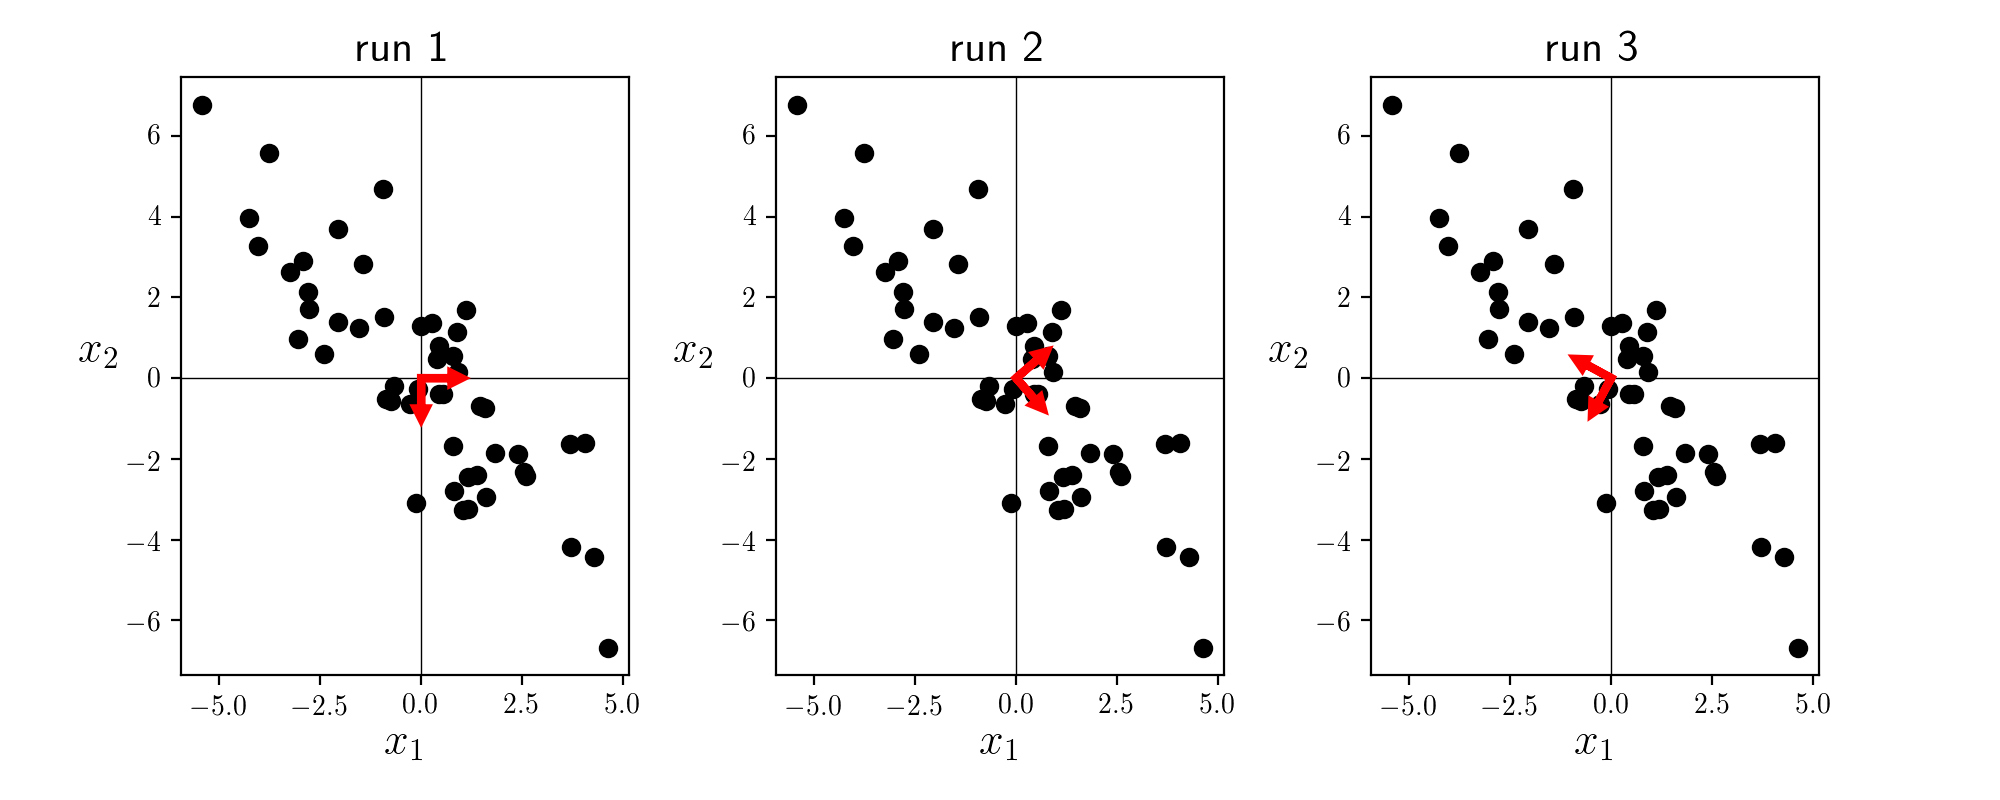

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# center data
X_means = np.mean(X_original,axis=1)[:,np.newaxis]
X = X_original - X_means

# make three runs of gradient descent to minimie the autoencoder, and plot the resulting
# principal components found
best_weights = []
num_runs = 3
for i in range(num_runs):
    # tune pca least squares cost
    g = autoencoder; alpha_choice = 10**(-2); max_its = 1000; C = 0.1*np.random.randn(2,2);
    weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,C)

    # pluck out best weights
    ind = np.argmin(cost_history)
    w_best = weight_history[ind]
    best_weights.append(w_best)
    
# plot all three autoencoder solutions
unsuplib.autoencoder_demos.visual_comparison(X,best_weights)

#### <span style="color:#a50e3e;">Example 4: </span> Learning an incomplete orthogonal bases via the autoencoder and gradient descent

Now we use our standard gradient descent optimizer to tune the parameters of the autoencoder for an $N = 2$ dimensional dataset, which has already been centered.  Here we will seek out only a single learned basis vector, and examine its final encoded and decoded versions visually.  

Below we plot a number of pictures resulting from minimizing the autoencoder.  Here we show the original data along with the learned basis element shown in the left panel, the encoded data in the middle panel i.e., the value of each learned weight $\mathbf{c}^T\mathbf{x}_p = w_p$, and the decoded data  $\mathbf{c}\mathbf{c}^T\mathbf{x}_p = \mathbf{c}w_p$ in the right panel.  In the right panel we also show the linear subspace (the span of the single basis vector $\mathbf{c}$ found) in red.

<IPython.core.display.Javascript object>


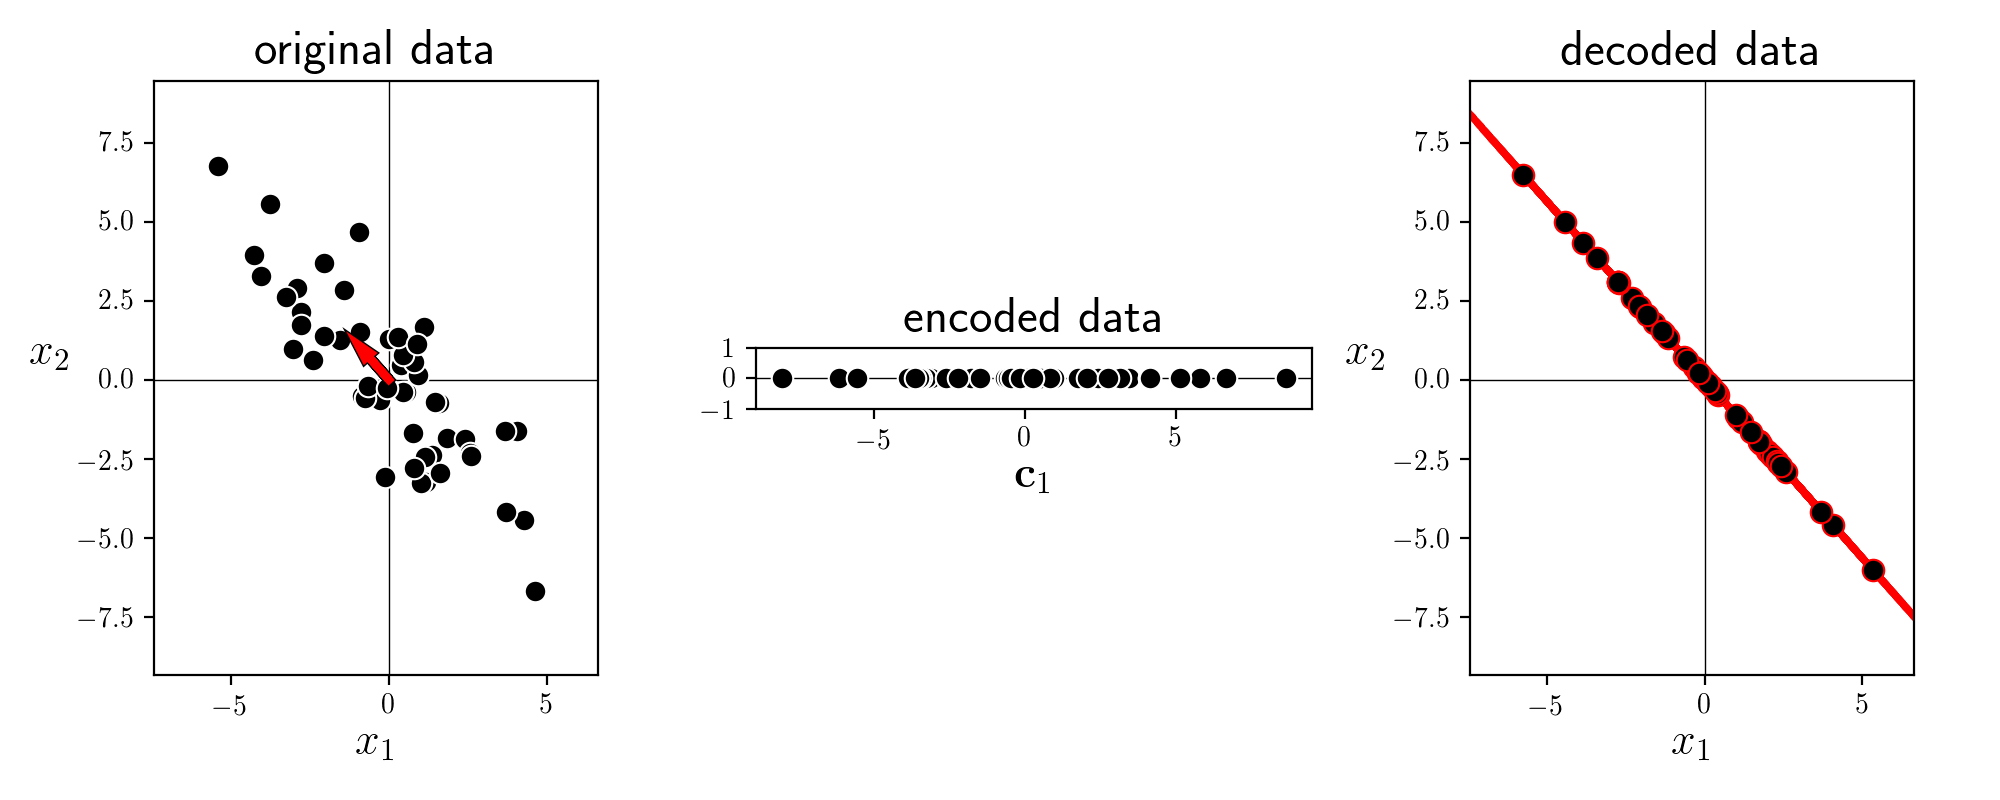

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# load in a dataset to learn a PCA basis for via the autoencoder
x = np.loadtxt(datapath + '2d_span_data_centered.csv',delimiter=',')

# tune the autoencoder via gradient descent
g = autoencoder; alpha_choice = 10**(-4); max_its = 1000; C = 0.1*np.random.randn(2,1);
C = np.array([[-3.5],[3.5]])
weight_history,cost_history = optimizers.gradient_descent(g,alpha_choice,max_its,C)

# display results of the autoencoder
unsuplib.autoencoder_demos.show_encode_decode(X,cost_history,weight_history,show_pc = True,scale = 150,encode_label = r'$\mathbf{c}_1$',projmap = False)

## 8.4.3 Formal proof that minima of the Autoencoder lie at orthogonal matrices $\mathbf{C}$

Here we show that the autoencoder cost is minimized when the $N \times K$ matrix $\mathbf{C}$ is orthogonal.  To do this recall the following important facts (discussed in our review Chapter on linear algebra)


- The matrix $\mathbf{C}\mathbf{C}^T$ is an *outer product matrix* and so has *all nonnegative* eigenvalues


- If $d_k$ is a nonnegative eigenvalue of $\mathbf{C}\mathbf{C}^T$, then $\sqrt{d_k }$ is an associated singular value of $\mathbf{C}$



- A matrix is orthogonal if and only if its singular values are all equal to $+1$

With these facts in hand we can now state the aim of our argument.  Below we will show that the autoencoder

\begin{equation}
g\left(\mathbf{C}\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \mathbf{C}_{\,}^{\,}\mathbf{C}_{\,}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2
\end{equation}

is minimized when the matrix $\mathbf{C}\mathbf{C}^T$  is orthogonal by showing that it achieves its minimum value when this matrix has all non-zero eigenvalues equal to $+1$. 

To do this we first re-write each summand by substituting in the eigenvector/value diagonalization for $\mathbf{C}\mathbf{C}^T$ 
as $\mathbf{C}\mathbf{C}^T = \mathbf{V}\mathbf{D}\mathbf{V}^T$ where $\mathbf{V}$ is an $N\times K$ orthogonal matrix of eigenvectors and $\mathbf{D}$ is a $K\times K$ diagonal matrix with all real eigenvalues along its diagonal,, and then following through with the squaring operation.  This gives

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  = \left \Vert \mathbf{V}\mathbf{D}\mathbf{V}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  =  \mathbf{x}_p^T \mathbf{V} \mathbf{D}\mathbf{D} \mathbf{V}^T \mathbf{x}_p   -2\mathbf{x}_p^T  \mathbf{V}\mathbf{D}\mathbf{V}^T \mathbf{x}_p + \mathbf{x}_p^T \mathbf{x}_p
\end{equation}

where note we have used the fact that $\mathbf{V}$ is orthogonal.  Now, denoting $\mathbf{A}^2 = \mathbf{A}\mathbf{A}$ for any square matrix $\mathbf{A}$ and setting $\mathbf{q}_p = \mathbf{V}\mathbf{x}_p$ (introducing $\mathbf{I}_{N\times N} = \mathbf{V}^T\mathbf{V}$ into the third term right of the final equality above) then we can drastically simplify the above to

\begin{equation}
\left \Vert \mathbf{C}_{\,}\mathbf{C}^T\mathbf{x}_p - \mathbf{x}_p \right\Vert_2^2  = \mathbf{q}_p^T \mathbf{D}\mathbf{D} \mathbf{q}_p   -2\mathbf{q}_p^T \mathbf{D} \mathbf{q}_p + \mathbf{q}_p^T \mathbf{q}_p = \mathbf{q}_p^T \left(\mathbf{D}^2 - 2\mathbf{D} + \mathbf{I}_{K\times K}\right)\mathbf{q}_p =  \mathbf{q}_p^T \left(\mathbf{D} - \mathbf{I}_{K\times K}\right)^2\mathbf{q}_p 
\end{equation}

Now let us take a moment to reflect on the expression above.  Our aim is to try and determine when the *sum* of such expressions

\begin{equation}
g\left(\mathbf{C}\right) = \sum_{p=1}^P \mathbf{q}_p^T \left(\mathbf{D} - \mathbf{I}_{K\times K}\right)^2\mathbf{q}_p 
\end{equation}

attains its minimum.  Note that since both $\mathbf{D}$ and $\mathbf{I}_{K\times K}$ are diagonal matrices, the matrix $\left(\mathbf{D} - \mathbf{I}_{K\times K}\right)^2$ too is diagonal (regardless of $\mathbf{D}$ with all nonnegative entries along its diagonal.  The autoencoder - irregardless of what form we write it in - is bounded below by $0$ - i.e., this is the smallest possible value the cost function can take.  

Now studying the form of the autoencoder we have come to above we can see that we can indeed achieve $g\left(\mathbf{C}\right) = 0$ is $\mathbf{D} = \mathbf{I}_{K\times K}$ or in other words when the matrix $\mathbf{C}\mathbf{C}^T$ has all non-zero eigenvalues equal to $+1$.  In such an instance this means that the matrix $\mathbf{C}$ has all *singular* values equal to $\sqrt{+1} = +1$ and so then $\mathbf{C}$ is indeed orthogonal.  

Therefore we have shown that the autoencoder is minimized only at orthogonal matrices $\mathbf{C}$.